## Pyspark Usage Notes

In this notebook, we cover basic use of `datashader`'s proposed [`pyspark`](https://spark.apache.org) backend. We reuse data and examples from the 2010 US Census data notebook since this is a non-trivial amount of data, but is still limited enough to be performant. We also replicate work with `datashader`'s `dask` backend for performance comparison. 

### Start `pyspark` session

There are many, many ways to manage Spark instances and connect to them. We do not attempt to cover them all here. This notebook is simply a demonstration of the `datashader` package given that you are connected to a Spark instance.

In this notebook, we are using Spark in local mode: all work is performed by the driver (master) process. This notebook is running off of a root `conda` environment's Jupyter installation with a custom `ipykernel` pointing to a [`datashader`-specific `conda` environment](https://github.com/bokeh/datashader/blob/master/examples/environment.yml). This environment also includes a `conda` installation of `pyspark`. Because of this setup, we need to discover and set the location of the Spark installation that we want to use. Otherwise, we would connect to the Spark installation at defined by the `SPARK_HOME` environment variable. If that location does not match the `conda` environment of this notebook, `pyspark` will not be able to distribute Python packages from the environment.

In [17]:
import findspark
import os
import sys

from pyspark.sql import SparkSession

# programatically determine SPARK_HOME in kernel conda environment
spark_home = os.path.join(os.path.dirname(os.path.dirname(sys.executable)),
                          "lib",
                          "python{v.major}.{v.minor}".format(v=sys.version_info),
                          "site-packages",
                          "pyspark")

# set SPARK_HOME
findspark.init(spark_home=spark_home, python_path=sys.executable)

# start a local SparkSession
spark = (SparkSession.builder
         .config("master", "local[1]")
         .config("spark.pyspark.python", sys.executable)
         .getOrCreate())
sc = spark.sparkContext

#### Notes on other deployment methods

1. Any distributed deployment of Spark will require more complicated configuration than above. The `conda` environment used in this notebook will need to be distributed to the executors (worker nodes) to make the Python modules available for executor-side computation. 

2. `datashader` uses `numba` for just-in-time (JIT) compilation of its reduction functions. The implementation requires caching the compiled functions. Depending on your cluster setup and user permissioning, this may require you to manually specify the `NUMBA_CACHE_DIR` environment variable on the executors. With YARN, for example, this can be set with the configuration parameter `"spark.executorEnv.NUMBA_CACHE_DIR"`. (This solution may also apply to other deployment modes, but I have no way of testing.)

### Load data and set up

First, let's load this data into a dataframe. This presents one complication: the default `parquet` format used by Python implementations (and therefore `dask`) is not directly compatible with Spark. This means the Census data packaged with `datashader`'s examples cannot be used directly. However, the fix is very simple: load the extant `parquet` dataset with `dask` and save it to a new location using `pyarrow`'s `flavor="spark"` option.

In [19]:
import dask.dataframe as dd

# read with dask 
ddf = dd.read_parquet('../data/census.snappy.parq')

# write in spark format to new location
# repartition to spark's recommended 128mb per partition
sdf_path = "../data/census_spark.snappy.parq"
if not os.path.exists(sdf_path):
    (ddf.repartition(npartitions=32)
     .to_parquet(sdf_path, engine="pyarrow", flavor="spark"))
    
# read with pyspark
sdf = spark.read.parquet(sdf_path)

Check both datasets:

In [22]:
%time len(ddf)

CPU times: user 16.2 s, sys: 4.02 s, total: 20.2 s
Wall time: 5.4 s


306675004

In [21]:
%time sdf.count()

CPU times: user 1.28 ms, sys: 1.21 ms, total: 2.49 ms
Wall time: 380 ms


306675004

There are 306675004 rows in these dataframes (one per person counted in the census), each with a location in Web Mercator format and a race encoded as a single character (where 'w' is white, 'b' is black, 'a' is Asian, 'h' is Hispanic, and 'o' is other (typically Native American)).

Let's define some geographic ranges to look at later, and also a default plot size.  Feel free to increase `plot_width` to 2000 or more if you have a very large monitor or want to save big files to disk, which shouldn't *greatly* affect the processing time or memory requirements.  

In [7]:
USA           = ((-124.72,  -66.95), (23.55, 50.06))
LakeMichigan  = (( -91.68,  -83.97), (40.75, 44.08))
Chicago       = (( -88.29,  -87.30), (41.57, 42.00))
Chinatown     = (( -87.67,  -87.63), (41.84, 41.86))
NewYorkCity   = (( -74.39,  -73.44), (40.51, 40.91))
LosAngeles    = ((-118.53, -117.81), (33.63, 33.96))
Houston       = (( -96.05,  -94.68), (29.45, 30.11))
Austin        = (( -97.91,  -97.52), (30.17, 30.37))
NewOrleans    = (( -90.37,  -89.89), (29.82, 30.05))
Atlanta       = (( -84.88,  -84.04), (33.45, 33.84))

from datashader.utils import lnglat_to_meters as webm
x_range,y_range = [list(r) for r in webm(*USA)]

plot_width  = int(900)
plot_height = int(plot_width*7.0/12)

Let's also choose a background color for our results.  A black background makes bright colors more vivid, and works well when later adding relatively dark satellite image backgrounds, but white backgrounds (`background=None`) are good for examining the weakest patterns, and work well when overlaying on maps that use light colors.  Try it both ways and decide for yourself!

In [8]:
background = "black"

We'll also need some utility functions and colormaps, and to make the page as big as possible:

In [9]:
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9
from IPython.core.display import HTML, display

export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

display(HTML("<style>.container { width:100% !important; }</style>"))

### Population density

For our first examples, let's ignore the race data for now, focusing on population density alone (as for the nyc_taxi.ipynb example).  We'll first aggregate all the points from the continental USA into a grid containing the population density per pixel.

In [10]:
cvs = ds.Canvas(plot_width, plot_height, *webm(*USA))

First, we aggregate with the `dask` backend:

In [23]:
%%time
dagg = cvs.points(ddf, 'easting', 'northing')

CPU times: user 8.4 s, sys: 4.9 s, total: 13.3 s
Wall time: 5.26 s


As shown in the Census notebook, this takes will take several seconds (about 5 seconds on a MacBook Pro). 

Next, we aggregate with the `pyspark` backend:

In [12]:
%%time
sagg = cvs.points(sdf, 'easting', 'northing')

CPU times: user 1.62 s, sys: 473 ms, total: 2.09 s
Wall time: 32min 7s


Well, that's much slower (about 30 minutes on a MacBook Pro). What's going on?

The `datashader.pyspark` implementation bootstraps Python code onto a Spark dataframe. This approach is not wholly different from the `datashader.dask` implementation. The performance difference is due to the serialization penalty paid to get `parquet` data into the Spark JVM, serialized to Python over a single-threaded socket connection, and deserialized in Python to an iterator of base types. As you can see from this test, this penalty can be enormous. We are definitely hurt by running Spark in local mode since the serialization cannot be parallelized. 

So is there a better way? Of course. It's to use Spark's in-built functionality to perform all necessary projections, discretization, and reduction and return only the pixel-level results to Python. 

`datashader`'s data operations can be broken into three pieces:
1. Projection: project numeric variables into the space of the plot. This includes transformation (e.g., identity or log) and filtering (to the plot's extent).
2. Discretization: discretize any continuous axis variables into pixels. This can be implemented as simple rescaling and floor division.
3. Reduction: aggregate the data grouped by the axis variable(s) and any additional (categorical) variables, applying one or more reduction functions to one or more variables.

Once these results are returned, they can be cast into the `xarray` format used by `datashader`'s plotting operations. Let's proof-of-concept this:

In [24]:
import numpy as np
import pyspark.sql.functions as F
import xarray

def discretize(col, min, max, pixels):
    """
    Discretization helper
    
    Parameters
    ----------
    col : pyspark.sql.Column
        Column to discretize
    min, max : float
        Minimum and maximum extents of col in the plot
    pixels : int
        Number of pixels for col in the plot
    
    Returns
    -------
    psypark.sql.Column
        Discretized (pixel-level) representation of col
    """
    return F.floor((col - min) / (max - min) * pixels)

In [25]:
%%time

project_discretize_reduce = (
    
    sdf
    
    # project; implicit identity transformation (no-op)
    .filter(F.col("easting").between(*cvs.x_range))
    .filter(F.col("northing").between(*cvs.y_range))
    
    # discretize
    .withColumn("x_pixel", discretize(F.col("easting"), *cvs.x_range, plot_width))
    .withColumn("y_pixel", discretize(F.col("northing"), *cvs.y_range, plot_height))
    
    # reduce
    .groupBy("x_pixel", "y_pixel")
    .count()
    
)

# above is lazy; this performs work
x_pixel, y_pixel, count = zip(*project_discretize_reduce.collect())

CPU times: user 871 ms, sys: 179 ms, total: 1.05 s
Wall time: 15.2 s


This is much more performant (about 15 seconds on a MacBook Pro). These results can now be cast into and `xarray` representation:

In [36]:
def get_coords(axis, range, pixels):
    s, t = axis.compute_scale_and_translate(range, pixels)
    px = np.arange(pixels) + 0.5
    return axis.inverse_mapper((px - t) / s)

_ = np.zeros((plot_height, plot_width), dtype="int32")
_[ybin, xbin] = count

manual_agg = xarray.DataArray(_, dims=("northing", "easting"), 
                              coords={"northing": get_coords(cvs.y_axis, cvs.y_range, cvs.plot_height), 
                                      "easting": get_coords(cvs.x_axis, cvs.x_range, cvs.plot_width)})

In [37]:
manual_agg

<xarray.DataArray (northing: 525, easting: 900)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
  * northing  (northing) float64 2.702e+06 2.709e+06 2.717e+06 2.724e+06 ...
  * easting   (easting) float64 -1.388e+07 -1.387e+07 -1.387e+07 -1.386e+07 ...

Results are identical between the `dask`, `pyspark`, and manual computations:

In [39]:
np.testing.assert_array_equal(dagg.data, sagg.data)
np.testing.assert_array_equal(sagg.data, manual_agg.data)
np.testing.assert_array_equal(dagg.coords, sagg.coords)
np.testing.assert_array_equal(sagg.coords, manual_agg.coords)

Now let's draw pretty pictures so we can at least feel good about ourselves:

In [51]:
import datashader.transfer_functions as tf
from colorcet import fire

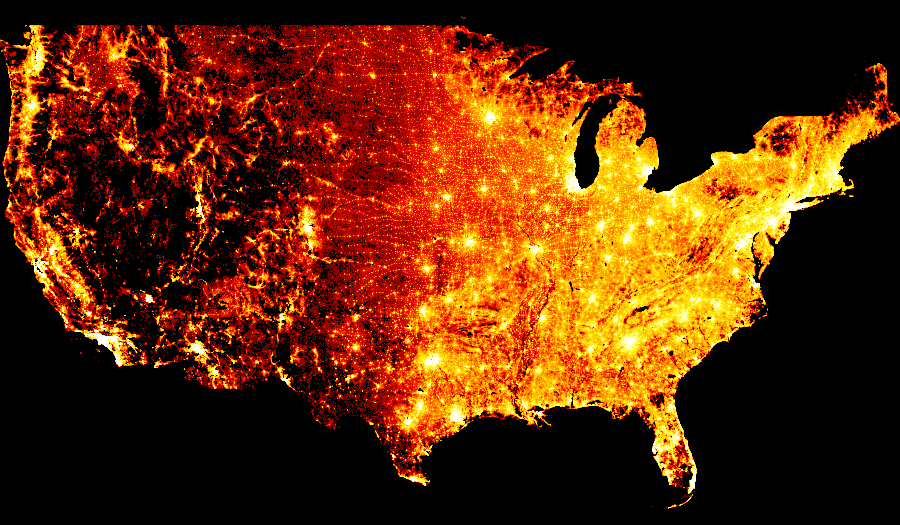

In [52]:
# dask
export(tf.shade(dagg, cmap = cm(fire,0.2), how='eq_hist'),"census_ds_fire_eq_hist")

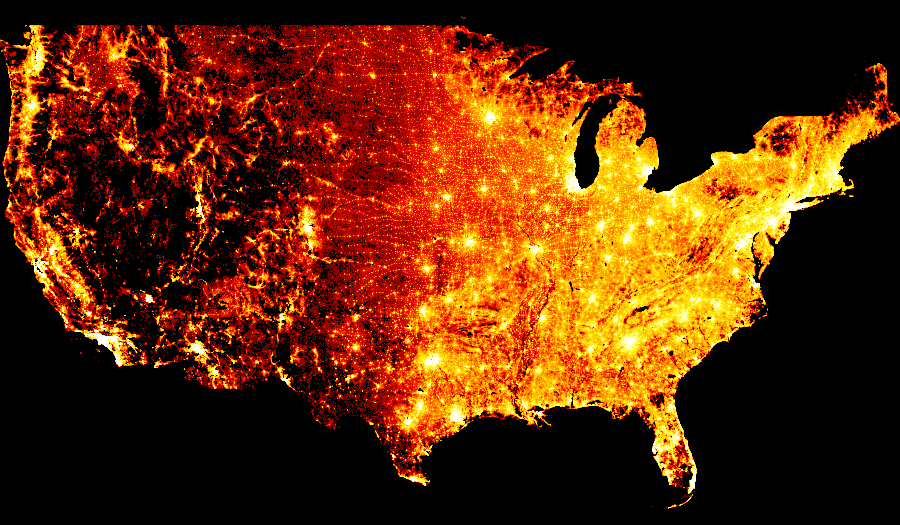

In [53]:
# pyspark
export(tf.shade(sagg, cmap = cm(fire,0.2), how='eq_hist'),"census_ds_fire_eq_hist")

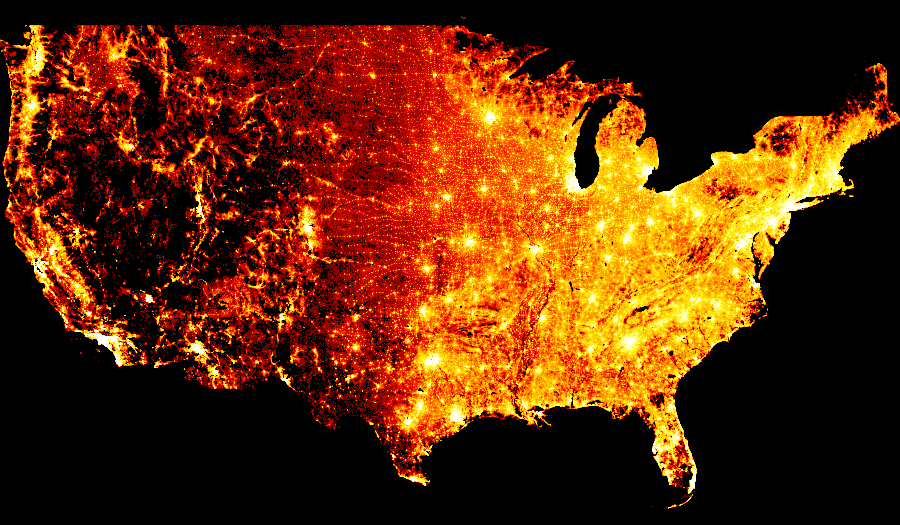

In [54]:
# manual
export(tf.shade(manual_agg, cmap = cm(fire,0.2), how='eq_hist'),"census_ds_fire_eq_hist")